In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from dataset import get_datasets
import numpy as np
import pickle
from cautious_extrapolation.data_paths import DATA_PATHS 
from cautious_extrapolation.utils import get_imagenet_features
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.special import softmax

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_loc = "nfs"

train_dataset, val_dataset, ood_datasets = get_datasets(DATA_PATHS[data_loc]["OfficeHome"])
eval_datasets = [val_dataset] + ood_datasets

In [19]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True)

val_features = get_imagenet_features(val_loader)

idxs = np.random.permutation(val_features.shape[0])
val_features = val_features[idxs]

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
ood_scores = []

for ood_dataset in ood_datasets:
    ood_loader = torch.utils.data.DataLoader(
        ood_dataset,
        batch_size=32, shuffle=True,
        num_workers=4, pin_memory=True)
    ood_features = get_imagenet_features(ood_loader)
    idxs = np.random.permutation(ood_features.shape[0])
    ood_features = ood_features[idxs]

    num_points = min(len(val_features), len(ood_features))
    ood_features_train = ood_features[:int(0.9*num_points)]
    val_features_train = val_features[:int(0.9*num_points)]


    X = np.concatenate((val_features[:int(0.9*num_points)], ood_features[:int(0.9*num_points)]), axis=0)
    y = np.concatenate((np.ones(int(0.9*num_points)), np.zeros(int(0.9*num_points))), axis=0)
    # idxs = np.random.permutation(2*num_points) 
    # X = X[idxs]
    # y = y[idxs]

    scores = []
    for _ in range(30):
        clf = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=20, alpha=10))
        clf.fit(X, y)
        score = clf.predict_log_proba(ood_features[int(0.9*num_points):])[:, 0].mean()
        scores.append(score)
    ood_scores.append(np.mean(scores))
ood_scores = np.array(ood_scores)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '

In [34]:
ood_scores

array([-0.59243684, -0.60647364, -0.63531635])

In [21]:
class_probs = []
targets = np.array(train_dataset.underlying_dataset.targets)[np.array(train_dataset.keys)]
for class_idx in range(65):
    class_probs.append(np.sum(np.array(targets) == class_idx)/len(train_dataset))
class_probs = np.array(class_probs)
f_star = class_probs*1+(1-class_probs)*-4
f_star = np.append(f_star, 0)

In [22]:
run_names = ["reward_prediction_seed0_2023_06_05_16_12_42", 
"reward_prediction_seed1_2023_06_05_21_18_16", 
"reward_prediction_seed2_2023_06_05_21_18_28", 
"reward_prediction_seed3_2023_06_05_21_18_44", 
"reward_prediction_seed4_2023_06_05_21_19_32"]

run_names_imitation = ["xent+1_seed1_2023_07_11_11_46_52",
"xent+1_seed2_2023_07_11_11_49_46",
"xent+1_seed3_2023_07_11_11_50_16",
"xent+1_seed4_2023_07_11_11_50_46",
"xent+1_seed5_2023_07_11_11_51_15"]

run_names_oracle = ["xent_seed0_2023_06_05_16_10_18",
"xent_seed1_2023_07_11_12_13_06",
"xent_seed2_2023_07_11_12_14_07",
"xent_seed3_2023_07_11_12_14_29",
"xent_seed4_2023_07_11_12_14_50"]

In [23]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
dataset_types = ['train', 'ood']


dist_from_f_star_all = []
for run_name in run_names:
    dist_from_f_star = []
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)
        for dataset_idx in range(4):
            dist_from_f_star.append(np.mean((data[dataset_idx] - np.expand_dims(f_star, axis=0))**2))
    dist_from_f_star_all.append(dist_from_f_star)
dist_from_f_star_all = np.array(dist_from_f_star_all)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  if sys.path[0] == "":


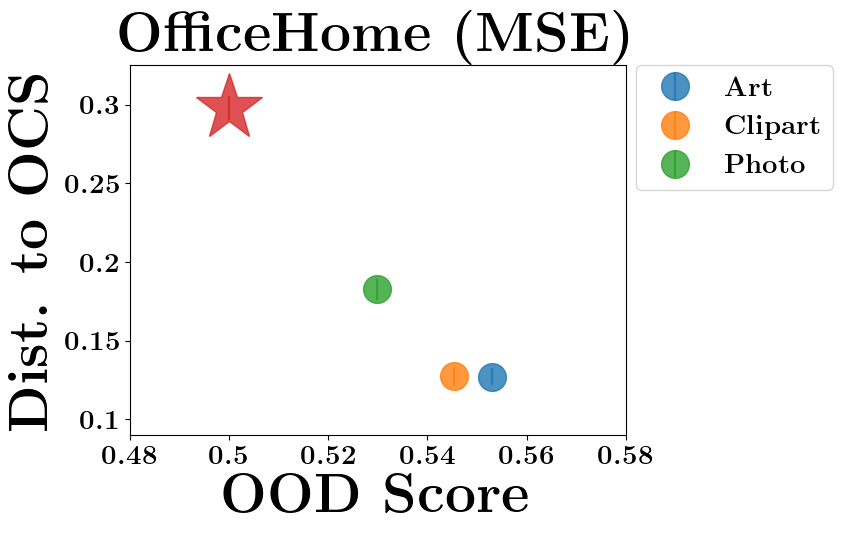

In [37]:
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pyplot as plt


#reset rcParams
plt.rcParams.update(plt.rcParamsDefault)


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

# plt.rcParams["figure.figsize"] = [2*5.3, 2*4.8]
plt.figure()
ax = plt.gca()
labels = ["Art", "Clipart", "Photo"]

plt.errorbar([0.5], [np.array(dist_from_f_star_all.mean(axis=0))[0]], yerr=[np.array(dist_from_f_star_all.std(axis=0))[0]], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
for i in range(1, 4):
    plt.errorbar([np.e**ood_scores[i-1]], [np.array(dist_from_f_star_all.mean(axis=0))[i]], yerr=[np.array(dist_from_f_star_all.std(axis=0))[i]], fmt='o', markersize=20, alpha=0.8, color=colors[i], label=r"\textbf{"+labels[i-1]+"}")


plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"$\mathbf{||f_{\theta}(x) - f^*_{constant}||^2}$", fontsize=40)
plt.ylabel(r"$\textbf{Dist. to OCS}$", fontsize=40)

plt.title(r"\textbf{OfficeHome (MSE)}", fontsize=40)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
ytick_labels = [r"\textbf{"+str(0.1)+"}", r"\textbf{"+str(0.15)+"}", r"\textbf{"+str(0.2)+"}", r"\textbf{"+str(0.25)+"}", r"\textbf{"+str(0.3)+"}"]
plt.yticks([0.1+_*0.05 for _ in range(5)], ytick_labels, fontsize=20)
xticks_labels = [r"\textbf{"+str(0.48)+"}", r"\textbf{"+str(0.5)+"}", r"\textbf{"+str(0.52)+"}", r"\textbf{"+str(0.54)+"}", r"\textbf{"+str(0.56)+"}", r"\textbf{"+str(0.58)+"}", r"\textbf{"+str(0.6)+"}"]
plt.xticks([0.48+0.02*_ for _ in range(7)], xticks_labels, fontsize=20)
plt.ylim([0.09, 0.325])
plt.xlim([0.48, 0.58])

plt.show()


In [38]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
dataset_types = ['train', 'ood']

dist_from_f_star_all = []
for run_name in run_names_oracle:
    dist_from_f_star = []
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)
        for dataset_idx in range(4):
            dist  = softmax(data[dataset_idx], axis=-1)
            dist_from_f_star.append(np.sum(dist*np.log(dist/np.expand_dims(class_probs, axis=0)), axis=-1).mean())
    dist_from_f_star_all.append(dist_from_f_star)
dist_from_f_star_all = np.array(dist_from_f_star_all)

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  if sys.path[0] == "":


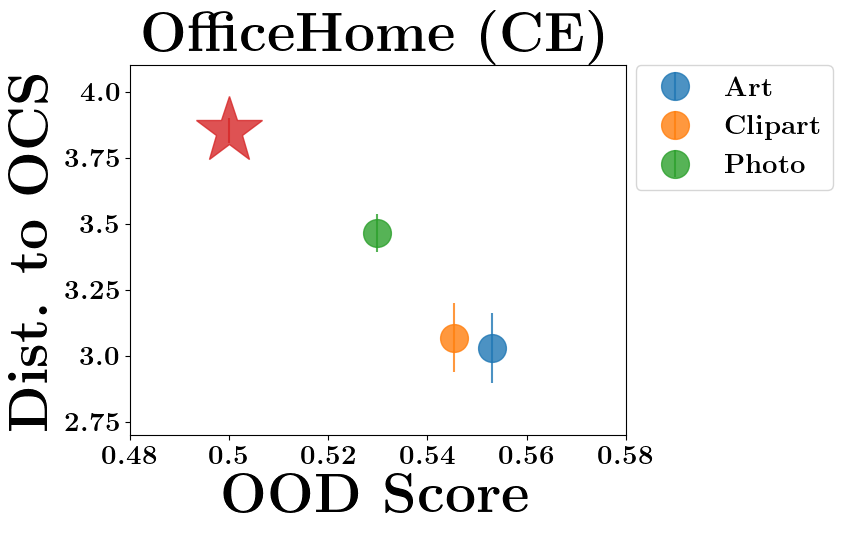

: 

In [45]:
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pyplot as plt


#reset rcParams
plt.rcParams.update(plt.rcParamsDefault)


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

plt.figure()
ax = plt.gca()
labels = ["Art", "Clipart", "Photo"]

plt.errorbar([0.5], [np.array(dist_from_f_star_all.mean(axis=0))[0]], yerr=[np.array(dist_from_f_star_all.std(axis=0))[0]], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
for i in range(1, 4):
    plt.errorbar([np.e**ood_scores[i-1]], [np.array(dist_from_f_star_all.mean(axis=0))[i]], yerr=[np.array(dist_from_f_star_all.std(axis=0))[i]], fmt='o', markersize=20, alpha=0.8, color=colors[i], label=r"\textbf{"+labels[i-1]+"}")


plt.xlabel(r"\textbf{OOD Score}", fontsize=40)
# plt.ylabel(r"$\mathbf{||f_{\theta}(x) - f^*_{constant}||^2}$", fontsize=40)
plt.ylabel(r"$\textbf{Dist. to OCS}$", fontsize=40)

plt.title(r"\textbf{OfficeHome (CE)}", fontsize=40)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., fontsize=20)
xticks_labels = [r"\textbf{"+str(0.48)+"}", r"\textbf{"+str(0.5)+"}", r"\textbf{"+str(0.52)+"}", r"\textbf{"+str(0.54)+"}", r"\textbf{"+str(0.56)+"}", r"\textbf{"+str(0.58)+"}", r"\textbf{"+str(0.6)+"}"]
plt.xticks([0.48+0.02*_ for _ in range(7)], xticks_labels, fontsize=20)

plt.yticks([2.5+_*0.25 for _ in range(10)], [r"\textbf{"+str(2.5+_*0.25)+"}" for _ in range(10)], fontsize=20)

plt.ylim([2.7, 4.1])
plt.xlim([0.48, 0.58])

plt.show()

In [7]:


rl_returns_all = np.zeros((5, 4))
rl_abstain_all = np.zeros((5, 4))
bc_returns_all = np.zeros((5, 4))
bc_abstain_all = np.zeros((5, 4))
oracle_returns_all = np.zeros((5, 4))
oracle_abstain_all = np.zeros((5, 4))
for j in range(4):
    if j == 0:
        labels = np.array(eval_datasets[j].underlying_dataset.targets)[eval_datasets[j].keys]
    else:
        labels = eval_datasets[j].targets
    one_hot = np.zeros((len(labels), 66))
    one_hot[np.arange(len(labels)), labels] = 1
    rewards = (4+1)*one_hot - 4
    rewards[:, -1] = 0

    rl_rewards_seed_corr = np.zeros((5, 6))
    rl_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        rl_run_name = run_names[i]
        outputs_all = pickle.load(open('data/{}/outputs.pkl'.format(rl_run_name), 'rb'))
        outputs = outputs_all[j]

        best_pred_actions = np.argmax(outputs, axis=-1)
        best_pred_rewards = rewards[np.arange(len(best_pred_actions)), best_pred_actions]
        rl_returns_all[i, j] = np.mean(best_pred_rewards)
        rl_abstain_all[i, j] = np.mean(best_pred_actions == 65)

    bc_rewards_seed_corr = np.zeros((5, 6))
    bc_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        bc_run_name = run_names_imitation[i]
        outputs_all = pickle.load(open('data/{}/outputs.pkl'.format(bc_run_name), 'rb'))
        outputs = outputs_all[j]
        best_pred_actions = np.argmax(outputs, axis=-1)
        best_pred_rewards = rewards[np.arange(len(best_pred_actions)), best_pred_actions]
        bc_returns_all[i, j] = np.mean(best_pred_rewards)
        bc_abstain_all[i, j] = np.mean(best_pred_actions == 65)

    oracle_rewards_seed_corr = np.zeros((5, 6))
    oracle_abstain_ratio_seed_corr = np.zeros((5, 6))
    for i in range(5):
        oracle_run_name = run_names_oracle[i]
        outputs_all = pickle.load(open('data/{}/outputs_ts.pkl'.format(oracle_run_name), 'rb'))
        outputs = outputs_all[j]
        outputs = softmax(outputs, axis=-1)
        output_dist_max = outputs.max(axis=-1)
        best_actions = np.argmax(outputs, axis=-1)
        threshold = 4/(1+4)
        certain = (output_dist_max > threshold)
        best_pred_actions = np.array(certain*best_actions + (1-certain)*np.ones(best_actions.shape)*65).astype(int)     
        oracle_returns_all[i, j] = rewards[np.arange(len(labels)), best_pred_actions].mean()
        oracle_abstain_all[i, j] = (best_pred_actions == 65).mean()

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


Text(0.5, 1.0, '\\textbf{OfficeHome}')

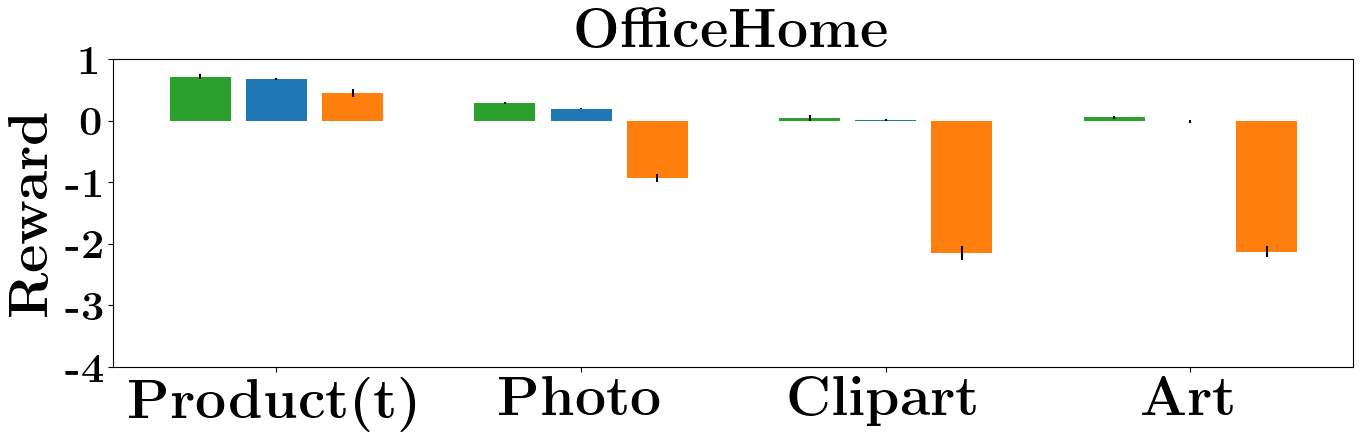

In [62]:


import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.rcParams["figure.figsize"] = (16,4)

plt.bar((np.arange(4)*4), np.mean(oracle_returns_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(oracle_returns_all, axis=0)[[0, 3, 2, 1]], color="C2")
plt.bar((np.arange(4)*4)+1, np.mean(rl_returns_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(rl_returns_all, axis=0)[[0, 3, 2, 1]], color="C0")
plt.bar((np.arange(4)*4)+2, np.mean(bc_returns_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(bc_returns_all, axis=0)[[0, 3, 2, 1]], color="C1")

plot_labels =  [r"\textbf{Product(t)}", r"\textbf{Photo}", r"\textbf{Clipart}",r"\textbf{Art}" ]

plt.xticks(np.arange(4)*4+1, plot_labels, fontsize=40)
plt.yticks(np.arange(-4, 2, 1), [r"\textbf{"+str(_)+"}" for _ in np.arange(-4, 2, 1)], fontsize=30)
plt.ylabel(r"\textbf{Reward}", fontsize=40)
plt.title(r"\textbf{OfficeHome}", fontsize=40)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


Text(0.5, 1.0, '\\textbf{OfficeHome}')

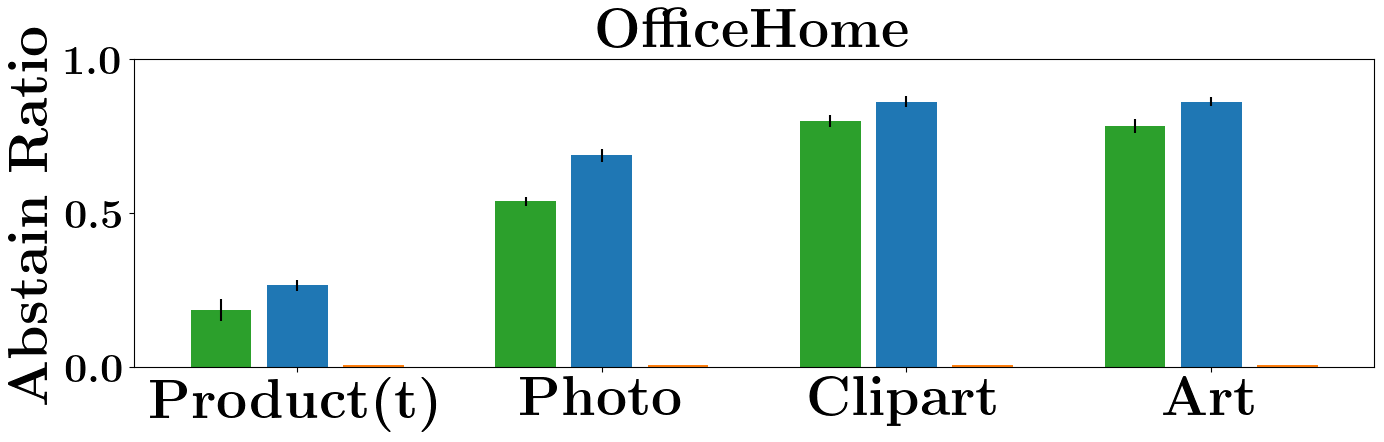

In [13]:


import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
plt.rcParams["figure.figsize"] = (16,4)

plt.bar((np.arange(4)*4), np.mean(oracle_abstain_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(oracle_abstain_all, axis=0)[[0, 3, 2, 1]], color="C2")
plt.bar((np.arange(4)*4)+1, np.mean(rl_abstain_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(rl_abstain_all, axis=0)[[0, 3, 2, 1]], color="C0")
plt.bar((np.arange(4)*4)+2, np.mean(np.clip(bc_abstain_all, a_min=0.005, a_max=1), axis=0)[[0, 3, 2, 1]], yerr=np.std(bc_abstain_all, axis=0)[[0, 3, 2, 1]], color="C1")

plot_labels =  [r"\textbf{Product(t)}", r"\textbf{Photo}", r"\textbf{Clipart}",r"\textbf{Art}" ]

plt.xticks(np.arange(4)*4+1, plot_labels, fontsize=40)
plt.yticks(np.arange(0, 1.5, 0.5), [r"\textbf{"+str(_)+"}" for _ in np.arange(0, 1.5, 0.5)], fontsize=30)
plt.ylabel(r"\textbf{Abstain Ratio}", fontsize=40)
plt.title(r"\textbf{OfficeHome}", fontsize=40)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


Text(0.5, 1.0, '\\textbf{LIVING-17 FAKE}')

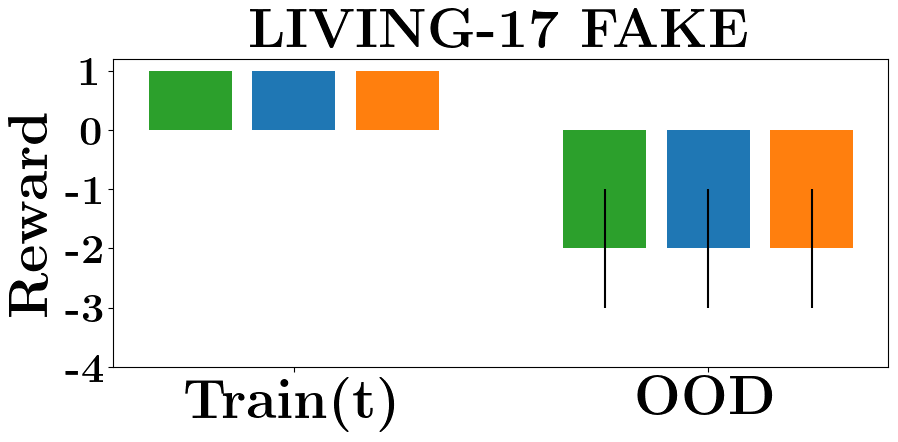

In [69]:

import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.rcParams["figure.figsize"] = (10,4)

plt.bar((np.arange(2)*4), [1, -2], yerr=[0, 1], color="C2")
plt.bar((np.arange(2)*4)+1, [1, -2], yerr=[0, 1], color="C0")
plt.bar((np.arange(2)*4)+2, [1, -2], yerr=[0, 1], color="C1")

# plt.bar((np.arange(4)*4)+1, np.mean(rl_returns_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(rl_returns_all, axis=0)[[0, 3, 2, 1]], color="C0")
# plt.bar((np.arange(4)*4)+2, np.mean(bc_returns_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(bc_returns_all, axis=0)[[0, 3, 2, 1]], color="C1")

plot_labels =  [r"\textbf{Train(t)}", r"\textbf{OOD}"]

plt.xticks(np.arange(2)*4+1, plot_labels, fontsize=40)
plt.yticks(np.arange(-4, 2, 1), [r"\textbf{"+str(_)+"}" for _ in np.arange(-4, 2, 1)], fontsize=30)
plt.ylabel(r"\textbf{Reward}", fontsize=40)
plt.title(r"\textbf{LIVING-17 FAKE}", fontsize=40)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


Text(0.5, 1.0, '\\textbf{NONLIVING-26 FAKE}')

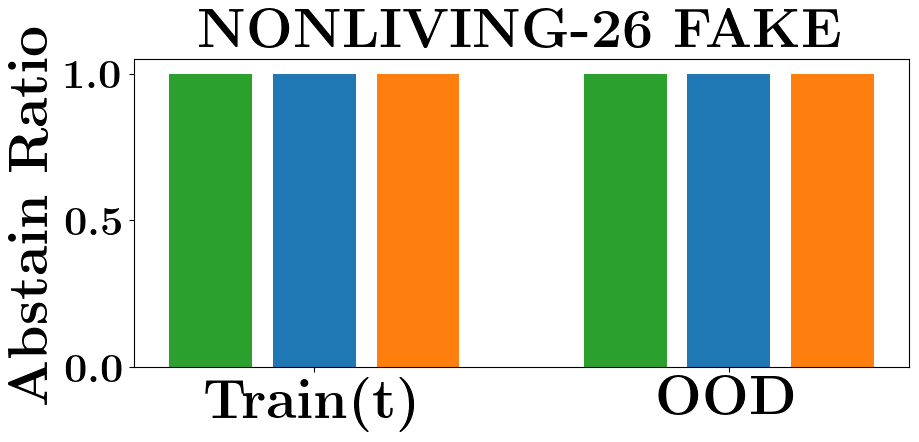

In [18]:

import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

plt.rcParams["figure.figsize"] = (10,4)

plt.bar((np.arange(2)*4), [1,  1], yerr=[0, 0], color="C2")
plt.bar((np.arange(2)*4)+1, [1, 1], yerr=[0, 0], color="C0")
plt.bar((np.arange(2)*4)+2, [1, 1], yerr=[0, 0], color="C1")

# plt.bar((np.arange(4)*4)+1, np.mean(rl_returns_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(rl_returns_all, axis=0)[[0, 3, 2, 1]], color="C0")
# plt.bar((np.arange(4)*4)+2, np.mean(bc_returns_all, axis=0)[[0, 3, 2, 1]], yerr=np.std(bc_returns_all, axis=0)[[0, 3, 2, 1]], color="C1")

plot_labels =  [r"\textbf{Train(t)}", r"\textbf{OOD}"]

plt.xticks(np.arange(2)*4+1, plot_labels, fontsize=40)
plt.yticks(np.arange(0, 1.5, 0.5), [r"\textbf{"+str(_)+"}" for _ in np.arange(0, 1.5, 0.5)], fontsize=30)
plt.ylabel(r"\textbf{Abstain Ratio}", fontsize=40)
plt.title(r"\textbf{NONLIVING-26 FAKE}", fontsize=40)